In [1]:
import pandas as pd
import numpy as np
import os as os
import yfinance as yf
import statsmodels.api as sm
import getFamaFrenchFactors as gff

# Plot settings
import matplotlib
import matplotlib.pyplot as plt
#Data Import
from yahooquery import Ticker

<h2> Portfolio Choice and Data</h2>
I have chosen to Vanguard Real Estate ETF (Ticker: VNQ) as my portfolio, which tracks MSCI US IMI Real Estate 25/50 Index,a market-cap-weighted index of companies involved in the ownership and operation of real estate in the United States.

<h3> Backtesting against Factors </h3>

Factors considered are the Fama French factors from 3 factor model

In [2]:
ticker = 'VNQ'
start = '2016-8-31'
end = '2021-8-31'

stock_data = yf.download(ticker, start, end, adjusted=True)

ff3_monthly = gff.famaFrench3Factor(frequency='m')
ff3_monthly.rename(columns={"date_ff_factors": 'Date'}, inplace=True)
ff3_monthly.set_index('Date', inplace=True)

stock_returns = stock_data['Adj Close'].resample('M').last().pct_change().dropna()
stock_returns.name = "Month_Rtn"
ff_data = ff3_monthly.merge(stock_returns,on='Date')

[*********************100%***********************]  1 of 1 completed


In [3]:
ff_data.head()

,Mkt-RF,SMB,HML,RF,Month_Rtn
Date,,,,,
2016-09-30,0.0025,0.0213,-0.0123,0.0002,-0.018326
2016-10-31,-0.0202,-0.0442,0.0412,0.0002,-0.057413
2016-11-30,0.0486,0.0567,0.0819,0.0001,-0.016757
2016-12-31,0.0181,0.0008,0.0356,0.0003,0.048172
2017-01-31,0.0194,-0.0114,-0.0276,0.0004,-0.001939


In [4]:
alpha = []
beta1 = []
beta2 = []
beta3 = []
timestamp = []

dates = ff_data.index
window_length = 24
index = 0
while((index+window_length) < len(ff_data)):
    #print("Index :{0}".format(index))
    data_win = ff_data.iloc[index : (index+window_length),:]
    X = data_win[['Mkt-RF', 'SMB', 'HML']]
    y = data_win['Month_Rtn'] - data_win['RF']
    X = sm.add_constant(X)
    ff_model = sm.OLS(y, X).fit()
    intercept, b1, b2, b3 = ff_model.params

    timestamp.append(dates[index])
    alpha.append(intercept)
    beta1.append(b1)
    beta2.append(b2)
    beta3.append(b3)

    index = index +1


In [5]:
df = pd.DataFrame(list(zip(alpha, beta1, beta2, beta3)),
               columns =['alpha', 'beta1','beta2','beta3'],index=timestamp)

df.head()

,alpha,beta1,beta2,beta3
2016-09-30,-0.007244,0.436796,0.421421,-0.257162
2016-10-31,-0.006860,0.427947,0.476909,-0.269419
2016-11-30,-0.001894,0.238545,0.340067,-0.131070
2016-12-31,0.002605,0.415949,0.466595,0.267188
2017-01-31,-0.000931,0.498671,0.477342,0.185247


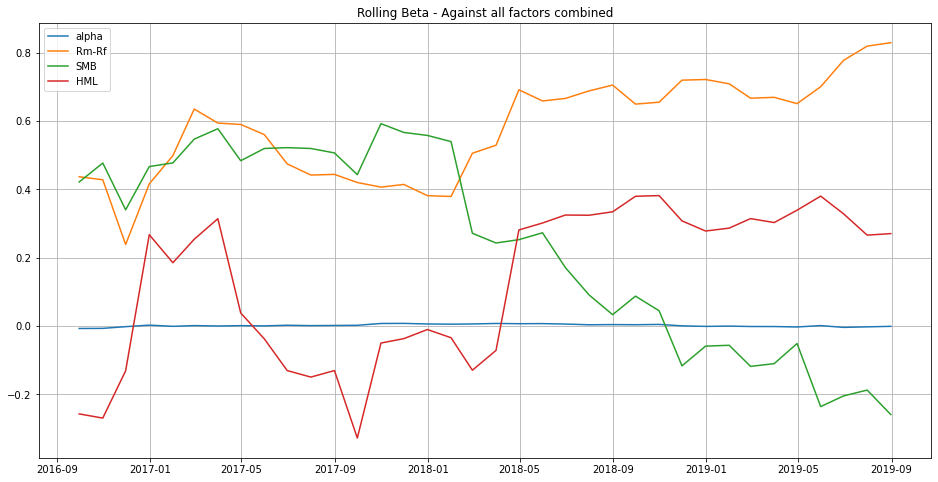

In [6]:
# Visualize the data
fig = plt.figure(figsize=(16,8))
ax = plt.axes()

ax.set_title('Rolling Beta - Against all factors combined')
ax.plot(df)
ax.legend(['alpha','Rm-Rf','SMB','HML'], loc='upper left')
ax.grid(True)


<h2> Black-Litterman Model </h2>


In [7]:
from numpy.linalg import inv

def as_colvec(x):
    if (x.ndim == 2):
        return x
    else:
        return np.expand_dims(x, axis=1)

def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu).values
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w

def w_mv(sigma,scale= True):
    """
    Optimal Portoflio weights for minimum vairance

    """
    i = np.ones(len(sigma))
    w = inverse(sigma).dot(i).values
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
        
    return w


def getdata(tickers,start_date,end_date):
    """
    Fetches Time Series data from Yahoo Finance for a list of tickers 
    """
    data = yf.download(list(tickers),start_date,end_date,adjusted= True)['Adj Close']
    return data


def get_covMatrix(rets):
    cov_Matrix = rets.cov() * 252   #Calculates annualized covariance matrix
    return cov_Matrix

#Assummes that Omega is proportional to the variance of the prior
def proportional_prior(sigma,tau,p):
    """
Returns the He Litterman simplified Omega
Inputs:
sigma: Variance-Covariance Matrix (N x N) as DataFrame
tau: a scalar
p: a K by K DataFrame linking Q and assets
returns a P by P DataFrame, a matrix representing prior uncertainties

    """
    heli_omega=p.dot(tau*sigma).dot(p.T)
    #Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(heli_omega.values)),index=p.index,columns=p.index)

def get_BL(omega_matrix, p_matrix, q_vector, tau,cov_mat,pi_vec): 
    """Implemented the exact version of the Black Littermnan Expected Return Formula"""   
    first_part =  inv(inv(tau*(cov_mat))+np.dot(np.dot(p_matrix.T, inv(omega_matrix)), p_matrix))
    second_part = np.dot(inv(tau*cov_mat), as_colvec(pi_vec)) + np.dot(np.dot(p_matrix.T, inv(omega_matrix)), q_vector)

    BLReturn = np.dot(first_part, second_part)
    BLReturn_df = pd.DataFrame(BLReturn,index=pi_vec.index,columns=['Return'])
    
    var_BL =  inv(inv(tau*(cov_mat))+np.dot(np.dot(p_matrix.T, inv(omega_matrix)), p_matrix))
    var_BL_df = pd.DataFrame(var_BL,index=pi_vec.index,columns=[pi_vec.index])
    return BLReturn_df,var_BL_df


Step1 : Getting the prior

We start by taking the current holdings as equilibrium weights for our analysis.

The equilibrium excess returns
$\pi = \lambda \Sigma w_{mkt} $

In [8]:
from yahooquery import Ticker
t = Ticker('VNQ')

# sector weightings, returns pandas DataFrame
t._fund_holdings
holdings = t.fund_holding_info['VNQ']['holdings']
symbols = []
weights =[]
for holding in holdings:
    symbols.append(holding['symbol'])
    weights.append(holding['holdingPercent'])

In [9]:
start_date = '2016-12-31'
end_date = '2022-12-31'
ts_data = getdata(symbols,start_date,end_date)

##Calculate returns##
returns = ts_data.pct_change().fillna(0)

##Calculate Covariance Matrix ##
sigma = get_covMatrix(returns)

## Calculate Equilibrium Returns ##
eql_returns = implied_returns(2.5,sigma,weights)

[*********************100%***********************]  10 of 10 completed


In [10]:
eql_returns

AMT      0.064978
CCI      0.061646
DLR      0.061198
EQIX     0.060322
PLD      0.062080
PSA      0.045022
SBAC     0.060381
SPG      0.055745
VRTPX    0.053909
WELL     0.059006
Name: Implied Returns, dtype: float64

In [11]:
weights = np.array(weights)/sum(np.array(weights))
wt_dict = dict(zip(symbols, weights))
wt_dict

{'VRTPX': 0.2524080565945886,
 'AMT': 0.16396672540272927,
 'PLD': 0.12302976822029285,
 'CCI': 0.10267075328955945,
 'EQIX': 0.09260070072811012,
 'PSA': 0.06282837141599906,
 'DLR': 0.055823117460208224,
 'SPG': 0.053196151605070394,
 'SBAC': 0.04838003513218047,
 'WELL': 0.04509632015126165}

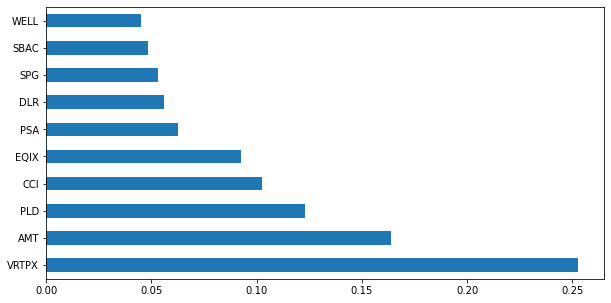

In [12]:

pd.Series(wt_dict).plot.barh(figsize=(10,5),);

Step 2: Inputing the Views 

Assuming some hypothetical Absolute views on AMT and EQIX, lets say we think AMT and EQIX will return 4% and 6% respectively 


In [13]:
view_count = 2
p = pd.DataFrame(dict(zip(symbols,np.zeros(10))),index=range(0,view_count,1))
p.loc[0,'AMT'] = 1
p.loc[1,'EQIX'] = 1
p

,VRTPX,AMT,PLD,CCI,EQIX,PSA,DLR,SPG,SBAC,WELL
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
q = pd.DataFrame({'AMT': 0.04 ,'EQIX':0.06},index=range(0,1,1))
q = q.T    # K- Element column vector
q

,0
AMT,0.04
EQIX,0.06


Step 3: Calculating posteriror returns

$$\Omega = diag(P (\tau \Sigma) P^T) $$
$$E(R) = = [(\tau \Sigma)^{-1} + P^{T}\Omega^{-1}P]^{-1} [(\tau \Sigma)^{-1}\Pi + P^{T}\Omega^{-1}Q]   $$

In [15]:
omega_matrix = proportional_prior(sigma,0.02,p)
p_matrix = p
q_vector= q
tau = 0.02
cov_mat = sigma

pi_vec = eql_returns


In [16]:
mu_BL,var_BL = get_BL(omega_matrix, p_matrix, q_vector, tau,cov_mat,pi_vec)     #Posterior Returns
mu_BL

,Return
AMT,0.057124
CCI,0.052086
DLR,0.054616
EQIX,0.054021
PLD,0.056830
PSA,0.040540
SBAC,0.052392
SPG,0.052210
VRTPX,0.048670
WELL,0.054269


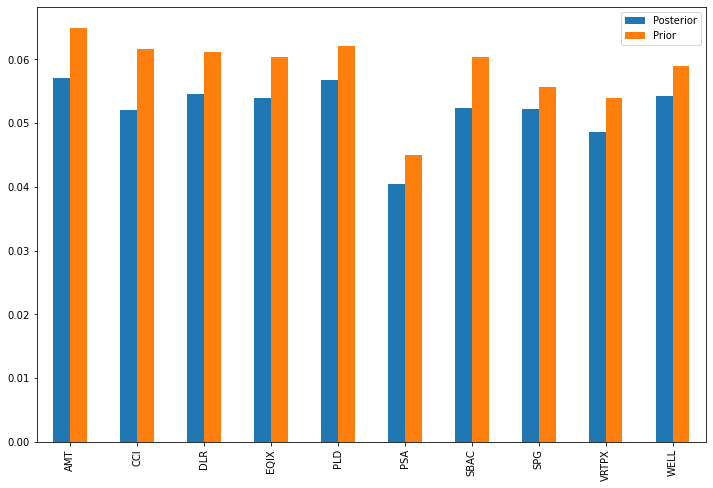

In [17]:
rets_df = mu_BL
rets_df['Prior'] = eql_returns
rets_df = rets_df.rename(columns={'Return':'Posterior'})


rets_df.plot.bar(figsize=(12,8));

In [18]:
var_BL

,AMT,CCI,DLR,EQIX,PLD,PSA,SBAC,SPG,VRTPX,WELL
AMT,0.000809,0.000495,0.000445,0.000478,0.000362,0.000324,0.000583,0.000281,0.000392,0.000389
CCI,0.000495,0.000616,0.000407,0.000387,0.000292,0.000271,0.000507,0.000197,0.000315,0.000276
DLR,0.000445,0.000407,0.001079,0.000699,0.000398,0.000352,0.000438,0.000162,0.000366,0.000205
EQIX,0.000478,0.000387,0.000699,0.001087,0.000410,0.000278,0.000503,0.000102,0.000357,0.000145
PLD,0.000362,0.000292,0.000398,0.000410,0.000700,0.000348,0.000326,0.000464,0.000427,0.000485
PSA,0.000324,0.000271,0.000352,0.000278,0.000348,0.000817,0.000256,0.000392,0.000375,0.000437
SBAC,0.000583,0.000507,0.000438,0.000503,0.000326,0.000256,0.000909,0.000081,0.000319,0.000202
SPG,0.000281,0.000197,0.000162,0.000102,0.000464,0.000392,0.000081,0.003485,0.000936,0.001841
VRTPX,0.000392,0.000315,0.000366,0.000357,0.000427,0.000375,0.000319,0.000936,0.000559,0.000779
WELL,0.000389,0.000276,0.000205,0.000145,0.000485,0.000437,0.000202,0.001841,0.000779,0.002248


Step 4: Updating the Asset Allocation

In [19]:
#Optimisation 1
#Get corresponding Max Sharp Ratio portfolio 
wt_msr_BL = w_msr(var_BL,mu_BL)

#Optimisation 2 
# Get the minimum variance portfolio

wt_mv_BL =  w_mv(var_BL)

In [20]:
weight_df = pd.DataFrame.from_dict(dict(zip(var_BL.index,wt_msr_BL.T[0])),orient='index',columns=['Max Sharpe Weights'])
weight_df['Minimum Variance Wights'] = pd.Series(dict(zip(var_BL.index,wt_mv_BL)))
weight_df

,Max Sharpe Weights,Minimum Variance Wights
AMT,0.118561,-0.048256
CCI,0.303835,0.301104
DLR,0.057790,-0.001767
EQIX,0.048227,0.036844
PLD,0.346959,0.138543
PSA,0.029512,0.169536
SBAC,0.026221,0.056143
SPG,0.024987,-0.027242
VRTPX,0.022725,0.415885
WELL,0.021183,-0.040790


<h2> Conclusion </h2>

1. Posterior Returns are observed to lie between prior and the view estimate.
2. We also observe that comapred to tradional optimisation methods Black Litterman based weights tend to be less noisy as the weights tend not to deviate much from the equilibrium weights.


<h3> Further Analysis </h2>

 Barring time limitations, one could have explored Machine Learning techniques for injecting more realistic views on the portfolio.